# Capstone 1 : Modelling

In this section, we will apply ML techniques to the transcript and the features we extracted to predict the ratings

In [40]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import NLP Modules
import spacy
import nltk
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to C:\Users\Pavan
[nltk_data]     Anirudh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Load data for modelling
df_clean = pd.read_csv('../data/processed/DataforModelling.csv', index_col = 0)
df_clean.index.name = "index"
df_clean.head(2)

,description,duration,event,main_speaker,speaker_occupation,tags,title,transcript,film_datestamp,pub_datestamp,...,word_per_min,tag_technology,tag_science,tag_global issues,tag_culture,tag_design,tag_business,tag_entertainment,clean_transcript,MaxRating_Class
index,,,,,,,,,,,,,,,,,,,,,
0,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,Ken Robinson,Author/educator,"['tag_children', 'tag_creativity', 'tag_cultur...",Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...,2006-02-25 00:00:00,2006-06-27 00:11:00,...,163,False,False,False,True,False,False,False,Good morning How are you It is been great ha...,5
1,With the same humor and humanity he exuded in ...,977,TED2006,Al Gore,Climate advocate,"['tag_alternative energy', 'tag_cars', 'tag_cl...",Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",2006-02-25 00:00:00,2006-06-27 00:11:00,...,127,True,True,True,True,False,False,False,Thank you so much Chris And it is truly a gr...,2


In [42]:
# Create class mapping
class_dict = ({'Fascinating': 1, 'BadTalk': 2, 'Beautiful':3,'Informative':4, 'Funny':5})


Text(0, 0.5, 'Number of talks')

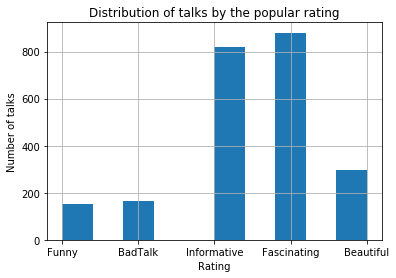

In [43]:
df_clean.Max_rating.hist()
plt.title('Distribution of talks by the popular rating')
plt.xlabel('Rating')
plt.ylabel('Number of talks')

In [44]:
df_clean.columns

Index(['description', 'duration', 'event', 'main_speaker',
       'speaker_occupation', 'tags', 'title', 'transcript', 'film_datestamp',
       'pub_datestamp', 'sentence_count', 'word_count', 'applause', 'laughter',
       'music', 'cheering', 'sighs', 'singing', 'video', 'audio', 'Funny',
       'Beautiful', 'Informative', 'Fascinating', 'Inspiring', 'event_type',
       'BadTalk', 'Max_rating', 'ratings_total', 'word_per_min',
       'tag_technology', 'tag_science', 'tag_global issues', 'tag_culture',
       'tag_design', 'tag_business', 'tag_entertainment', 'clean_transcript',
       'MaxRating_Class'],
      dtype='object')

In [45]:
df_clean.shape

(2314, 39)

### Assemble feature vector

We will make a feature matrix by combining the word count matrix and the metadata matrix 

In [46]:
# Define predictors and other rating vectors
y_Funny = df_clean[['Funny']]
y_Informative = df_clean[['Informative']]
y_Inspiring = df_clean[['Inspiring']]

y_MaxRating = df_clean[['MaxRating_Class']].to_numpy(dtype = int)

In [47]:
# Define metadata fields
X_metadata = df_clean[['duration', 'sentence_count', 'word_count', 'applause', 'laughter',
       'music', 'cheering', 'sighs', 'singing', 'video', 'audio', 'event_type', 'ratings_total',
       'word_per_min', 'tag_technology', 'tag_science', 'tag_global issues',
       'tag_culture', 'tag_design']]
X_metadata.shape

(2314, 19)

In [48]:
event_onehot = pd.get_dummies(X_metadata.event_type,prefix='event')

In [49]:
X_metadata_new = X_metadata.join(event_onehot)
X_metadata_new.drop(columns = ['event_type'], inplace = True)
X_metadata_new.shape

(2314, 27)

In [50]:
from scipy import sparse
metadata_np = X_metadata_new.to_numpy(dtype = float)
metadata_sparse = sparse.csr_matrix(metadata_np)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
# vectorizer_predict = CountVectorizer(stop_words = stopwords.words('english'), min_df = 0.01, max_df = 0.98)
vectorizer = CountVectorizer(stop_words = stopwords.words('english'), min_df = 0.01)

In [52]:
vectorizer.fit(df_clean.clean_transcript)
X_transcript = vectorizer.transform(df_clean.clean_transcript)


In [53]:
X_transcript.shape

(2314, 6945)

In [54]:
# Combine wordvectorizer matrix and metadata matrix to get the final feature matrix
X_features = sparse.hstack((X_transcript, metadata_sparse))
X_features

<2314x6972 sparse matrix of type '<class 'numpy.float64'>'
	with 1007196 stored elements in COOrdinate format>

In [55]:
feature_dict_vocab = vectorizer.vocabulary_
# feature_dict = feature_dict_vocab
word_ix_max = max(feature_dict_vocab.values())
word_ix_max

6944

In [56]:
feature_dict = dict([[v,k] for k,v in feature_dict_vocab.items()])
# for key in feature_dict_vocab 
for col_name in X_metadata_new.columns:
    col_ix = X_metadata_new.columns.get_loc(col_name)
    new_key = col_ix +word_ix_max+1
    feature_dict[new_key] = 'metadata_'+col_name
#     print (new_key , feature_dict[new_key])
# feature_dict



In [57]:
X_metadata_new.iloc[:,1]

index
0       223
1       141
2       250
3       179
4       236
       ... 
2462     61
2463     34
2464     72
2465    135
2466     84
Name: sentence_count, Length: 2314, dtype: int64

In [58]:
max(feature_dict.values())

'zoom'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B6428A8F88>]],
      dtype=object)

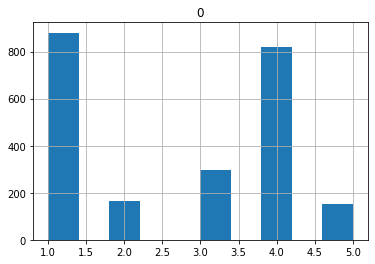

In [59]:
# Plot the number of talks in each class
pd.DataFrame(y_MaxRating).hist()

As can be seen, we have unbalanced classes in our dataset. We can overcome this by oversampling the rating groups with fewer number of talks


### Train Models and Predict

The classifiers being tried for prediction on this dataset are
1. Logistic Regression
2. Support Vector Machine 
3. Naive Bayes
4. Random Forest



In [60]:
# Create Training and Test split
X_train, X_test, y_train, y_test = train_test_split(X_features, (y_MaxRating), test_size = 0.20)

In [61]:
# Define FUnction for Cross Validation. 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func = roc_auc_score):
    result = 0
    nfold = 3
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # Fit model
        result += score_func(clf.predict(x[test]), y[test], multi_class = 'ovo') # evaluate score function on held-out data
        
    return result / nfold # average
    

### 1. Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

In [72]:
y_train = y_train[:,0]

In [77]:
lr_clf = LogisticRegression(class_weight = 'balanced', multi_class = 'ovr', C = 1, max_iter= 100, solver = 'newton-cg')
# Fit the model on the trainng data.
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_train)

# Calculate accuracy score using balanced accuracy scores
print ('Balanced accuracy score (training)is ', balanced_accuracy_score(lr_clf.predict(X_train), y_train, adjusted = True))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(lr_clf.predict(X_test), y_test, adjusted = True))


Balanced accuracy score (training)is  1.0
Balanced accuracy score (test)is  0.4289231601731601


In [78]:
# Make scorer
from sklearn.metrics import fbeta_score, make_scorer
bal_acc_scorer = make_scorer(balanced_accuracy_score, adjusted = True)
roc_auc_scorer = make_scorer(roc_auc_score)
# >>> from sklearn.model_selection import GridSearchCV
# >>> from sklearn.svm import LinearSVC

In [85]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
C_ls = np.logspace(-5, 0, num=10)
param_grid = {'C':C_ls}
clf = GridSearchCV(lr_clf, param_grid, scoring = bal_acc_scorer, n_jobs = -1)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([ 9.22391205, 10.25372658, 14.99114237, 16.39345064, 18.93969955,
        23.7592001 , 25.06046858, 29.57038016, 35.36656942, 30.0895824 ]),
 'std_fit_time': array([0.81426244, 1.02420292, 1.01231214, 0.62346727, 0.41504015,
        1.83276694, 1.08197058, 2.23430896, 1.66832852, 5.83886503]),
 'mean_score_time': array([0.01249704, 0.00635462, 0.00844297, 0.00651507, 0.0109786 ,
        0.00339112, 0.00259953, 0.00478716, 0.00831184, 0.00260363]),
 'std_score_time': array([0.00624852, 0.00778461, 0.0062026 , 0.00506487, 0.0071341 ,
        0.00279265, 0.00332423, 0.00239358, 0.00640627, 0.0019515 ]),
 'param_C': masked_array(data=[1e-05, 3.5938136638046256e-05, 0.0001291549665014884,
                    0.0004641588833612782, 0.0016681005372000592,
                    0.005994842503189409, 0.021544346900318846,
                    0.07742636826811278, 0.2782559402207126, 1.0],
              mask=[False, False, False, False, False, False, False, False,
          

In [88]:
lr_clf_cvsearch = clf.best_estimator_
print ('Best score is', clf.best_score_)
print ('Score on test set is', balanced_accuracy_score(lr_clf_cvsearch.predict(X_test), y_test))


Best score is 0.4614290227791564
Score on test set is 0.555682380167506


In [89]:
print ('Value of C chosen from parameter search is', lr_clf_cvsearch.get_params()['C'])

Value of C chosen from parameter search is 0.0016681005372000592


In [92]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lr_clf_cvsearch.predict(X_test), labels = [1,2,3,4,5])

array([[109,   3,   9,  30,  10],
       [  8,   3,   7,  16,   0],
       [  7,   6,  42,   6,   1],
       [ 29,   6,   9, 130,   5],
       [  1,   1,   2,   0,  23]], dtype=int64)

We can see from the confusion matrix that the hardest class to predict for the classifier is class 2, on BadTalk. Most likely this is due to this class being a grouping of several other classes

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_clf_cvsearch.predict(X_test)))

              precision    recall  f1-score   support

           1       0.71      0.68      0.69       161
           2       0.16      0.09      0.11        34
           3       0.61      0.68      0.64        62
           4       0.71      0.73      0.72       179
           5       0.59      0.85      0.70        27

    accuracy                           0.66       463
   macro avg       0.56      0.60      0.57       463
weighted avg       0.65      0.66      0.65       463



In [94]:
class_dict

{'Fascinating': 1, 'BadTalk': 2, 'Beautiful': 3, 'Informative': 4, 'Funny': 5}

Confusion matrix, without normalization
[[109   3   9  30  10]
 [  8   3   7  16   0]
 [  7   6  42   6   1]
 [ 29   6   9 130   5]
 [  1   1   2   0  23]]
Normalized confusion matrix
[[0.67701863 0.01863354 0.05590062 0.1863354  0.0621118 ]
 [0.23529412 0.08823529 0.20588235 0.47058824 0.        ]
 [0.11290323 0.09677419 0.67741935 0.09677419 0.01612903]
 [0.16201117 0.03351955 0.05027933 0.72625698 0.02793296]
 [0.03703704 0.03703704 0.07407407 0.         0.85185185]]


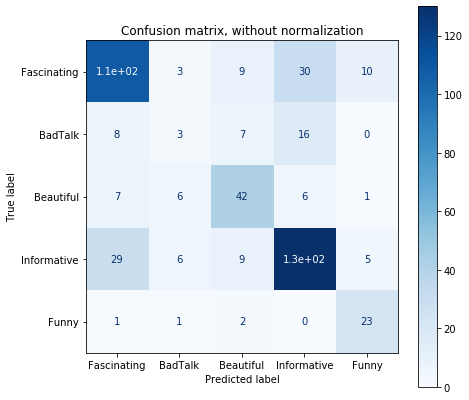

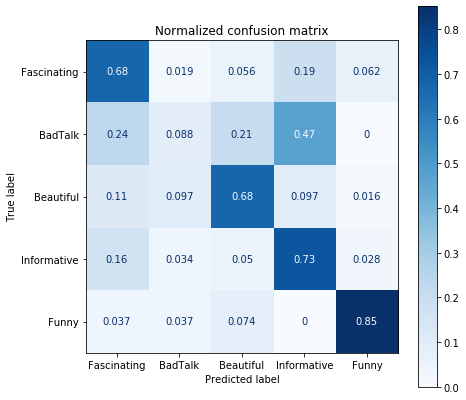

In [136]:
# Plotting the confusion Matrix
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr_clf_cvsearch, X_test, y_test,
                                 display_labels=list(class_dict.keys()),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches((7,7))

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [96]:
roc_auc_score(lr_clf.predict_proba(X_train),y_train,  multi_class="ovo", average='macro')

ValueError: continuous-multioutput format is not supported

### 2. Naive Bayes Classification

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Calculate accuracy score using balanced accuracy scores
print ('Balanced accuracy score (training)is ', balanced_accuracy_score(nb.predict(X_train), y_train))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(nb.predict(X_test), y_test))


Balanced accuracy score (training)is  0.5138175598165404
Balanced accuracy score (test)is  0.4203960029923242


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\ProgramData\Anaconda3\lib\site-packag

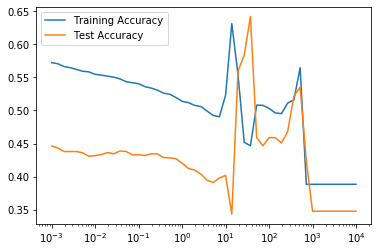

In [98]:
# Hyperparameter optimization
alpha_ls = np.logspace(-3, 4, num=50)
train_accuracy_ls = []
test_accuracy_ls = []
for alpha in alpha_ls:
    nb = MultinomialNB(alpha = alpha)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    
    train_accu = balanced_accuracy_score(nb.predict(X_train), y_train)
    test_accu = balanced_accuracy_score(nb.predict(X_test), y_test)
    train_accuracy_ls.append(train_accu)
    test_accuracy_ls.append(test_accu)

# Plotting
# fig, ax = plt.subplot()
plt.plot(alpha_ls, train_accuracy_ls, label = 'Training Accuracy')
plt.plot(alpha_ls, test_accuracy_ls, label = 'Test Accuracy')
plt.xscale('log') 
plt.legend()



In [99]:
# Parameter selection using GridSearchCV
alpha_ls = np.logspace(-1, 4, num=10)
param_grid = {'alpha':alpha_ls}
nb_clf = GridSearchCV(nb, param_grid, scoring = bal_acc_scorer)
nb_clf.fit(X_train, y_train)
nb_clf.cv_results_


{'mean_fit_time': array([0.00929394, 0.00777898, 0.00837669, 0.00735064, 0.00798783,
        0.00778928, 0.00878248, 0.00778208, 0.00758176, 0.00858231]),
 'std_fit_time': array([0.00133381, 0.00074619, 0.00119671, 0.00081393, 0.0006217 ,
        0.00074209, 0.00145886, 0.00096798, 0.00078542, 0.00134711]),
 'mean_score_time': array([0.00198503, 0.00139632, 0.00199542, 0.00165281, 0.00179663,
        0.00120702, 0.00140405, 0.00159602, 0.00138969, 0.00323701]),
 'std_score_time': array([0.00088018, 0.0004886 , 0.00063128, 0.00055118, 0.00039966,
        0.00039414, 0.00049827, 0.00048798, 0.00048041, 0.00247161]),
 'param_alpha': masked_array(data=[0.1, 0.35938136638046275, 1.291549665014884,
                    4.641588833612779, 16.68100537200059,
                    59.94842503189409, 215.44346900318845,
                    774.2636826811278, 2782.559402207126, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
  

In [100]:
# Find optimal alpha : it appears to be close to 1000 based on above plot
optimal_alpha = nb_clf.best_params_['alpha']
optimal_alpha

1.291549665014884

In [101]:
nb_clf_gridcv = nb_clf.best_estimator_

In [102]:
# # Retraining with optimal alpha at 23.35
# nb = MultinomialNB(alpha = optimal_alpha)
# nb.fit(X_train, y_train)
# y_pred = nb.predict(X_test)

# Calculate accuracy score using balanced accuracy scores
print ('Balanced accuracy score (training)is ', balanced_accuracy_score(nb_clf_gridcv.predict(X_train), y_train))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(nb_clf_gridcv.predict(X_test), y_test))


Balanced accuracy score (training)is  0.513956550727326
Balanced accuracy score (test)is  0.4144403279222191


In [103]:
class_dict.keys()

dict_keys(['Fascinating', 'BadTalk', 'Beautiful', 'Informative', 'Funny'])

In [104]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, nb_clf_gridcv.predict(X_test), labels = [1,2,3,4,5])

array([[ 51,  40,   7,  32,  31],
       [  1,  16,   4,  13,   0],
       [  2,  31,  17,   4,   8],
       [ 23,  26,  10, 100,  20],
       [  3,   5,   3,   0,  16]], dtype=int64)

We see much lower performance compared to Logistic Regression. But, interestingly, NB seems to predict BadTalk better. 
In order to improve the performance further, we will try to over-sample the dataset to get rid of class imbalance in our dataset. 


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_clf_gridcv.predict(X_test)))

              precision    recall  f1-score   support

           1       0.64      0.32      0.42       161
           2       0.14      0.47      0.21        34
           3       0.41      0.27      0.33        62
           4       0.67      0.56      0.61       179
           5       0.21      0.59      0.31        27

    accuracy                           0.43       463
   macro avg       0.41      0.44      0.38       463
weighted avg       0.56      0.43      0.46       463



In [106]:
X_train.shape, y_train.shape

((1851, 6972), (1851,))

In [107]:
from imblearn.over_sampling import SMOTE, ADASYN

In [108]:
X_sm, y_sm = SMOTE('minority').fit_resample(X_train, y_train)
# X_sm, y_sm = ADASYN('minority').fit_resample(X_train, y_train)

In [109]:
print (X_sm.shape, y_sm.shape)

(2443, 6972) (2443,)


In [110]:
# Train NB with the new resampled class
alpha_ls = np.logspace(-1, 4, num=10)
param_grid = {'alpha':alpha_ls}
nb_clf_sm = GridSearchCV(nb, param_grid, scoring = bal_acc_scorer)
nb_clf_sm.fit(X_sm, y_sm)


GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=10000.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-01, 3.59381366e-01, 1.29154967e+00, 4.64158883e+00,
       1.66810054e+01, 5.99484250e+01, 2.15443469e+02, 7.74263683e+02,
       2.78255940e+03, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(balanced_accuracy_score, adjusted=True),
             verbose=0)

In [111]:
# Find optimal alpha : it appears to be close to 1000 based on above plot
optimal_alpha = nb_clf.best_params_['alpha']
optimal_alpha

1.291549665014884

In [112]:
# DEfine new best estimator
nb_clf_sm_cvsearch = nb_clf_sm.best_estimator_

In [113]:
# Calculate accuracy score using balanced accuracy scores
print ('Balanced accuracy score (training)is ', balanced_accuracy_score(nb_clf_sm_cvsearch.predict(X_train), y_train))
print ('Balanced accuracy score (SMOTE train)is ', balanced_accuracy_score(nb_clf_sm_cvsearch.predict(X_sm), y_sm))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(nb_clf_sm_cvsearch.predict(X_test), y_test))


Balanced accuracy score (training)is  0.5342873643270338
Balanced accuracy score (SMOTE train)is  0.5744089469301645
Balanced accuracy score (test)is  0.43103577656086023


Confusion matrix, without normalization
[[ 51  40   7  32  31]
 [  1  16   4  13   0]
 [  2  31  17   4   8]
 [ 23  26  10 100  20]
 [  3   5   3   0  16]]
Normalized confusion matrix
[[0.31677019 0.2484472  0.04347826 0.19875776 0.19254658]
 [0.02941176 0.47058824 0.11764706 0.38235294 0.        ]
 [0.03225806 0.5        0.27419355 0.06451613 0.12903226]
 [0.12849162 0.1452514  0.05586592 0.55865922 0.11173184]
 [0.11111111 0.18518519 0.11111111 0.         0.59259259]]


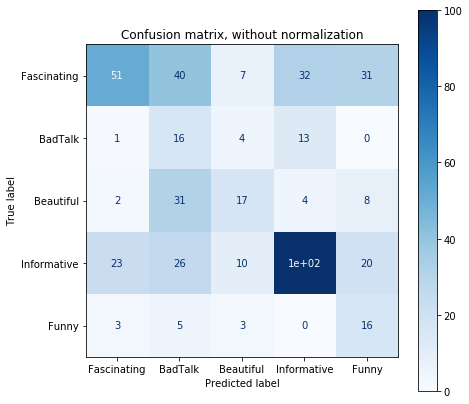

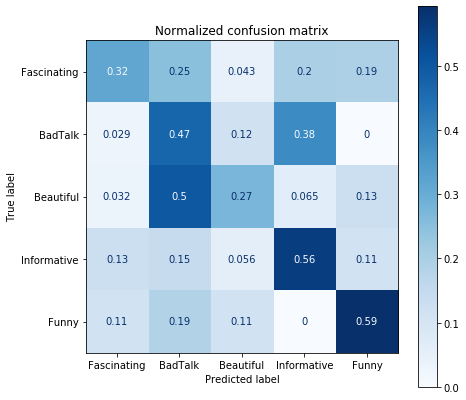

In [137]:
# Plotting the confusion Matrix
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb_clf_gridcv, X_test, y_test,
                                 display_labels=list(class_dict.keys()),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches((7,7))

    print(title)
    print(disp.confusion_matrix)

plt.show()

### 3. Random Forest Classification

In [115]:
from sklearn.ensemble import RandomForestClassifier


In [116]:
clf_rf = RandomForestClassifier(n_estimators = 150, min_samples_split = 20)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

print ('Balanced accuracy score (training)is ', balanced_accuracy_score(clf_rf.predict(X_train), y_train))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(clf_rf.predict(X_test), y_test))


Balanced accuracy score (training)is  0.988278324915585
Balanced accuracy score (test)is  0.708144913976818


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


We get an balanced accuracy score(test) of 0.73 when we train the model without sampling. Lets try with sampling

In [117]:
clf_rf_sm = RandomForestClassifier(n_estimators = 150, min_samples_split = 20)
clf_rf_sm.fit(X_sm, y_sm)
y_pred = clf_rf_sm.predict(X_test)

print ('Balanced accuracy score (training)is ', balanced_accuracy_score(clf_rf_sm.predict(X_train), y_train))
print ('Balanced accuracy score (sampled)is ', balanced_accuracy_score(clf_rf_sm.predict(X_sm), y_sm))
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(clf_rf_sm.predict(X_test), y_test))


Balanced accuracy score (training)is  0.9855541868946694
Balanced accuracy score (sampled)is  0.9855541868946694
Balanced accuracy score (test)is  0.738003663003663


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Here sampling does not seem to impact the classifier perforamnace significantly. So, we will continue with training our model on sampled data

In [118]:
clf_rf_sm.n_features_

6972

In [119]:
feature_imp = clf_rf_sm.feature_importances_

In [120]:
imp_feature_ix = np.argsort(feature_imp)[::-1] # in decreasing order
imp_feature_ix

array([6949, 6956, 6922, ..., 1461,  610,    0], dtype=int64)

In [121]:
print ('Top Predictors are:')
print ('feature \t | \t importance')
for ix in range(10):
    print (feature_dict[imp_feature_ix[ix]] + '\t | \t'+str(feature_imp[imp_feature_ix[ix]]))
    

Top Predictors are:
feature 	 | 	 importance
metadata_laughter	 | 	0.014822539297028122
metadata_ratings_total	 | 	0.00915019266324882
yeah	 | 	0.006518589328020453
metadata_tag_technology	 | 	0.0065113601878016
fun	 | 	0.005915263887696662
love	 | 	0.005054796247055871
percent	 | 	0.00500537386591622
guy	 | 	0.004910282386878262
technology	 | 	0.004571069245282155
metadata_word_count	 | 	0.004155436936333285


In [122]:
### Hyperparameter Tuning
clf_rf_sm.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [123]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
# Number of tress to consider
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 500, num = 25)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}


In [124]:
# pprint(random_grid)
print (random_grid)

{'n_estimators': [100, 255, 411, 566, 722, 877, 1033, 1188, 1344, 1500], 'max_features': ['log2', 'sqrt'], 'max_depth': [1, 21, 42, 63, 84, 104, 125, 146, 167, 188, 208, 229, 250, 271, 292, 312, 333, 354, 375, 396, 416, 437, 458, 479, 500, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]}


In [125]:
rf_sm = RandomForestClassifier()
# Random serach based on 3-fold cross validation
rf_random = RandomizedSearchCV(estimator = rf_sm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, scoring = bal_acc_scorer, n_jobs = -1)

In [126]:
# fit random serach model
rf_random.fit(X_sm, y_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [127]:
# Best parameters
rf_random.best_params_

{'n_estimators': 1033,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 42,
 'bootstrap': False}

In [128]:
# Get the performance of best estimator
rf_randomcv_best = rf_random.best_estimator_
y_pred_test = rf_randomcv_best.predict(X_test)
print ('Balanced accuracy score (test)is ', balanced_accuracy_score(y_pred_test, y_test))


Balanced accuracy score (test)is  0.7485258196966973


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Confusion matrix, without normalization
[[130   0   0  31   0]
 [ 12   0   0  22   0]
 [ 29   0   7  26   0]
 [ 58   0   1 120   0]
 [ 20   0   0   2   5]]
Normalized confusion matrix
[[0.80745342 0.         0.         0.19254658 0.        ]
 [0.35294118 0.         0.         0.64705882 0.        ]
 [0.46774194 0.         0.11290323 0.41935484 0.        ]
 [0.32402235 0.         0.00558659 0.67039106 0.        ]
 [0.74074074 0.         0.         0.07407407 0.18518519]]


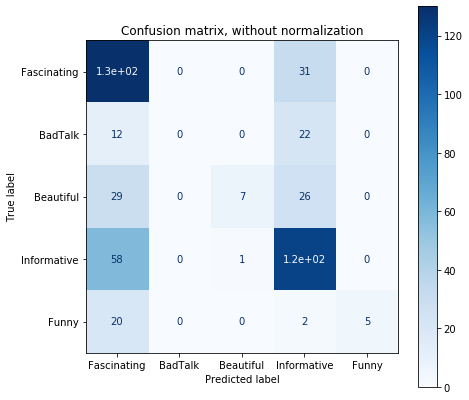

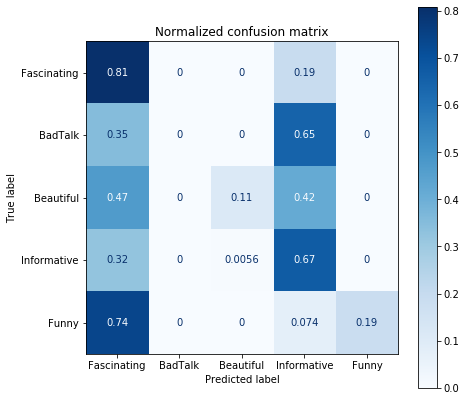

In [138]:
# On this best estimator, confusion matrix is 
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf_randomcv_best, X_test, y_test,
                                 display_labels=list(class_dict.keys()),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches((7,7))

    print(title)
    
    print(disp.confusion_matrix)

plt.show()

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_randomcv_best.predict(X_test)))

              precision    recall  f1-score   support

           1       0.52      0.81      0.63       161
           2       0.00      0.00      0.00        34
           3       0.88      0.11      0.20        62
           4       0.60      0.67      0.63       179
           5       1.00      0.19      0.31        27

    accuracy                           0.57       463
   macro avg       0.60      0.36      0.36       463
weighted avg       0.59      0.57      0.51       463



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion

We see the perforamnce of three different classifiers on predicting the rating of the TED talks. WE see Logistric regression to have the best performance, followed by random forests and Naive Bayes classifier 